# Load data

In [72]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
import preprocessing
import os
import xrft
import gcm_filters
import random

warnings.filterwarnings("ignore")

importlib.reload(preprocessing)
from preprocessing import preprocess_data

from gcm_filtering import filter_inputs_dataset
from gcm_filtering import filter_inputs

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
ds_merged = preprocess_data()
ds_merged

Load Data
Interpolating ocean velocities
Modify units
Load Data
Align in time
Interpolating ocean velocities
Regrid Atmospheric Data
Modify units
Mask nans
Calculate relative wind


<xarray.Dataset> Size: 3TB
Dimensions:       (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time          (time) object 58kB 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.85 79.95
  * yt_ocean      (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.94 89.98
    area_t        (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t      (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ht            (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    kmt           (yt_ocean, xt_ocean) float32 39MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    wet           (yt_ocean, xt_ocean) float64 78MB dask.array<chunksize=(2700, 3600), meta=np.ndarray>
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

## Training dataset creation

### Output data

In [3]:
Qstar = xr.open_dataset(
    "gs://leap-persistent/panalluri/Qstar.zarr", engine="zarr", chunks={}
)
Qstar

<xarray.Dataset> Size: 284GB
Dimensions:   (time: 7305, yt_ocean: 2700, xt_ocean: 3600)
Coordinates:
  * time      (time) object 58kB 0181-01-01 12:00:00 ... 0200-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    data      (time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(3, 2700, 3600), meta=np.ndarray>

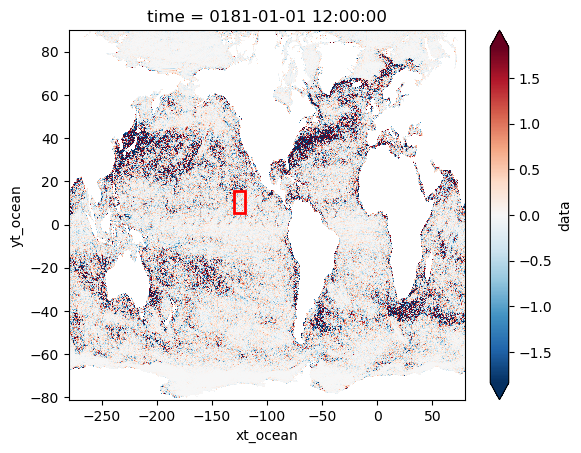

In [41]:
Qstar.data.isel(time=0).plot(robust=True)

lat_min, lat_max = 5.54134386, 15.36255392  # Replace with your actual values
lon_min, lon_max = -129.95, -119.95  # Replace with your actual values

# Draw the box on the plot
plt.gca().add_patch(
    plt.Rectangle(
        (lon_min, lat_min),  # (x, y) start point
        lon_max - lon_min,   # width
        lat_max - lat_min,   # height
        fill=False,          # don't fill the box
        edgecolor='red',     # color of the box
        linewidth=2
    )
)

# Show the plot
plt.show()

In [45]:
Qstar_sample = Qstar.isel(time=slice(0,365), xt_ocean=slice(1500,1600), yt_ocean=slice(1300,1400))
Qstar_sample

<xarray.Dataset> Size: 15MB
Dimensions:   (time: 365, yt_ocean: 100, xt_ocean: 100)
Coordinates:
  * time      (time) object 3kB 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * xt_ocean  (xt_ocean) float64 800B -130.0 -129.9 -129.8 ... -120.2 -120.1
  * yt_ocean  (yt_ocean) float64 800B 5.541 5.641 5.74 ... 15.07 15.17 15.27
Data variables:
    data      (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>

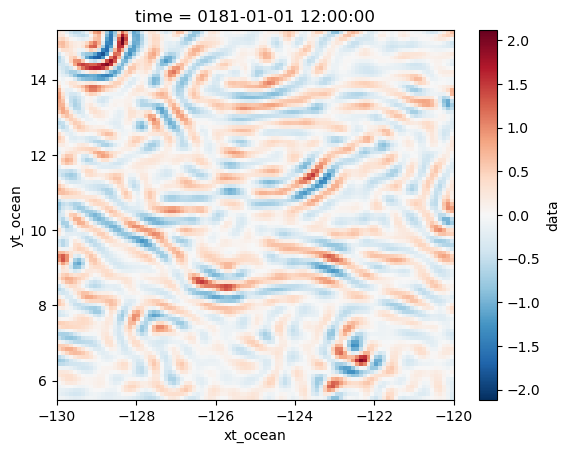

In [46]:
Qstar_sample.data.isel(time=0).plot()

In [88]:
Qstar_NN = Qstar_sample.isel(time=0) 
Qstar_NN

<xarray.Dataset> Size: 42kB
Dimensions:   (yt_ocean: 100, xt_ocean: 100)
Coordinates:
    time      object 8B 0181-01-01 12:00:00
  * xt_ocean  (xt_ocean) float64 800B -130.0 -129.9 -129.8 ... -120.2 -120.1
  * yt_ocean  (yt_ocean) float64 800B 5.541 5.641 5.74 ... 15.07 15.17 15.27
Data variables:
    data      (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>

In [89]:
## From when NN data was through time, not space

#Qstar_stacked = Qstar_NN.stack(spatial=['xt_ocean', 'yt_ocean'])
#Qstar_stacked

### Input data

In [82]:
ds_in = ds_merged
ds_in = ds_in.drop(['area_t', 'dxt', 'dyt', 'geolat_t', 'geolon_t', 'ht', 'kmt', 'wet'])

print("Filtering model")
ds_out = filter_inputs_dataset(ds_in, ['yt_ocean', 'xt_ocean'], filter_scale=50, filter_type='gaussian')

ds_lowRes = ds_out.isel(time=slice(0,365), xt_ocean=slice(1500,1600), yt_ocean=slice(1300,1400))
ds_lowRes

Filtering model


<xarray.Dataset> Size: 161MB
Dimensions:       (time: 365, xt_ocean: 100, yt_ocean: 100)
Coordinates:
  * time          (time) object 3kB 0181-01-01 12:00:00 ... 0181-12-31 12:00:00
  * xt_ocean      (xt_ocean) float64 800B -130.0 -129.9 -129.8 ... -120.2 -120.1
  * yt_ocean      (yt_ocean) float64 800B 5.541 5.641 5.74 ... 15.07 15.17 15.27
Data variables:
    slp           (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    v_ref         (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    u_ref         (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    t_ref         (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    q_ref         (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    wind          (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    surface_temp  (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    u_ocean       (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    v_ocean       (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    u_relative    (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
    v_relative    (time, yt_ocean, xt_ocean) float32 15MB dask.array<chunksize=(3, 100, 100), meta=np.ndarray>
Attributes:
    filter_scale:  50
    filter_type:   gaussian

In [83]:
ds_lowRes_NN = ds_lowRes.isel(time=0)
ds_lowRes_NN

<xarray.Dataset> Size: 442kB
Dimensions:       (xt_ocean: 100, yt_ocean: 100)
Coordinates:
    time          object 8B 0181-01-01 12:00:00
  * xt_ocean      (xt_ocean) float64 800B -130.0 -129.9 -129.8 ... -120.2 -120.1
  * yt_ocean      (yt_ocean) float64 800B 5.541 5.641 5.74 ... 15.07 15.17 15.27
Data variables:
    slp           (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    v_ref         (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    u_ref         (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    t_ref         (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    q_ref         (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    wind          (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    surface_temp  (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    u_ocean       (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    v_ocean       (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    u_relative    (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
    v_relative    (yt_ocean, xt_ocean) float32 40kB dask.array<chunksize=(100, 100), meta=np.ndarray>
Attributes:
    filter_scale:  50
    filter_type:   gaussian

In [93]:
u_rel = ds_lowRes_NN.u_relative
v_rel = ds_lowRes_NN.v_relative
sst = ds_lowRes_NN.surface_temp
t_ref = ds_lowRes_NN.t_ref

In [84]:
## From when samples were taken through time, not space

#u_rel_stacked = ds_lowRes_halo.u_relative.stack(spatial=['xt_ocean', 'yt_ocean'])
#v_rel_stacked = ds_lowRes_halo.v_relative.stack(spatial=['xt_ocean', 'yt_ocean'])
#sst_stacked = ds_lowRes_halo.surface_temp.stack(spatial=['xt_ocean', 'yt_ocean'])
#t_ref_stacked = ds_lowRes_halo.t_ref.stack(spatial=['xt_ocean', 'yt_ocean'])

## NN architecture setup

In [85]:
class SGS_HF(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(4, 8)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(8, 4)
        self.act2 = nn.ReLU()
        self.output = nn.Linear(4, 1)
 
    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.output(x)
        return x
 
model = SGS_HF()
print(model)

SGS_HF(
  (hidden1): Linear(in_features=4, out_features=8, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=8, out_features=4, bias=True)
  (act2): ReLU()
  (output): Linear(in_features=4, out_features=1, bias=True)
)


In [86]:
print(model)

SGS_HF(
  (hidden1): Linear(in_features=4, out_features=8, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=8, out_features=4, bias=True)
  (act2): ReLU()
  (output): Linear(in_features=4, out_features=1, bias=True)
)


In [87]:
loss_fn = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [103]:
n_epochs = 5
batch_size = 3

for epoch in range(n_epochs):    
    for i in range(0, 31, batch_size): 
        
        # Prepare batch data
        x_urel = torch.tensor(u_rel.isel(xt_ocean=slice(i, i+batch_size), yt_ocean=slice(0,3)).stack(spatial=['xt_ocean', 'yt_ocean']).values, dtype=torch.float32)
        x_vrel = torch.tensor(v_rel.isel(xt_ocean=slice(i, i+batch_size), yt_ocean=slice(0,3)).stack(spatial=['xt_ocean', 'yt_ocean']).values, dtype=torch.float32)
        x_sst = torch.tensor(sst.isel(xt_ocean=slice(i, i+batch_size), yt_ocean=slice(0,3)).stack(spatial=['xt_ocean', 'yt_ocean']).values, dtype=torch.float32)
        x_tref = torch.tensor(t_ref.isel(xt_ocean=slice(i, i+batch_size), yt_ocean=slice(0,3)).stack(spatial=['xt_ocean', 'yt_ocean']).values, dtype=torch.float32)
        
        # Concatenate features along the feature dimension (dim=1)
        Xbatch = torch.stack((x_urel, x_vrel, x_sst, x_tref), dim=1)
        
        # Forward pass
        y_pred = model(Xbatch) 
        
        # Prepare target data
        ybatch = torch.tensor(Qstar_NN.isel(xt_ocean=slice(i, i+batch_size), yt_ocean=slice(0,3)).stack(spatial=['xt_ocean', 'yt_ocean']).data.values, dtype=torch.float32)
        
        # Compute loss
        loss = loss_fn(y_pred.squeeze(), ybatch)  

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()        # Compute gradients (backpropagation)
        optimizer.step()       # Update model parameters
        
        print(f'Batch {i // batch_size}, loss {loss.item()}')
        
    print(f'Finished epoch {epoch}, latest loss {loss.item()}')


Batch 0, loss 4234.7138671875
Batch 1, loss 4159.33447265625
Batch 2, loss 4052.80029296875
Batch 3, loss 3956.967529296875
Batch 4, loss 3880.973876953125
Batch 5, loss 3777.51611328125
Batch 6, loss 3696.1318359375
Batch 7, loss 3650.11328125
Batch 8, loss 3536.096923828125
Batch 9, loss 3426.000732421875
Batch 10, loss 3352.824951171875
Finished epoch 0, latest loss 3352.824951171875
Batch 0, loss 3330.222900390625
Batch 1, loss 3273.27392578125
Batch 2, loss 3188.6923828125
Batch 3, loss 3113.567626953125
Batch 4, loss 3056.091796875
Batch 5, loss 2974.180419921875
Batch 6, loss 2911.63916015625
Batch 7, loss 2880.276123046875
Batch 8, loss 2788.30810546875
Batch 9, loss 2699.5810546875
Batch 10, loss 2643.420654296875
Finished epoch 1, latest loss 2643.420654296875
Batch 0, loss 2631.468505859375
Batch 1, loss 2589.223876953125
Batch 2, loss 2522.219970703125
Batch 3, loss 2463.4453125
Batch 4, loss 2420.0966796875
Batch 5, loss 2354.81591796875
Batch 6, loss 2306.69580078125
Batc

In [104]:
torch.save(model.state_dict(), 'leap-persistent/panalluri/airSeaTrial1NN.pth')

In [105]:
torch.save(model, 'leap-persistent/panalluri/airSeaTrial1NN_wholeModel.pth')

In [90]:
## From when training data stepped through time, not space

#n_epochs = 5
#batch_size = 9
#
#for epoch in range(n_epochs):
#    for i in range(0, 80, batch_size): #look at enumerate function for index, i
#        index = i // batch_size
#        
#        # Prepare batch data
#        x_urel = torch.tensor(u_rel_stacked.isel(time=index).values, dtype=torch.float32)
#        x_vrel = torch.tensor(v_rel_stacked.isel(time=index).values, dtype=torch.float32)
#        x_sst = torch.tensor(sst_stacked.isel(time=index).values, dtype=torch.float32)
#        x_tref = torch.tensor(t_ref_stacked.isel(time=index).values, dtype=torch.float32)
#        
#        # Concatenate features along the feature dimension (dim=1)
#        Xbatch = torch.stack((x_urel, x_vrel, x_sst, x_tref), dim=1)
#        
#        # Forward pass
#        y_pred = model(Xbatch) 
#        
#        # Prepare target data
#        ybatch = torch.tensor(Qstar_stacked.isel(time=index).data.values, dtype=torch.float32)
#        
#        # Compute loss
#        loss = loss_fn(y_pred.squeeze(), ybatch)  
#
#        # Backward pass and optimization
#        optimizer.zero_grad()  # Clear previous gradients
#        loss.backward()        # Compute gradients (backpropagation)
#        optimizer.step()       # Update model parameters
#        
#        print(f'Batch {i // batch_size}, loss {loss.item()}')
#        
#    print(f'Finished epoch {epoch}, latest loss {loss.item()}')
